In [1]:
library(Seurat)
library(RColorBrewer)
library(ggplot2)
library(anndataR)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [2]:
out_dir <- "../../results/05_fibroblast/11_ECM_score"

if(!dir.exists(out_dir)){
    dir.create(out_dir, recursive = TRUE)
}

In [3]:
adata <- anndataR::read_h5ad('../../results/05_fibroblast/01_clustering/fibroblast.h5ad')

In [4]:
# convert data to Seurat object
counts <- t(as.matrix(adata$layers$counts))
colnames(counts) <- adata$obs_names
rownames(counts) <- adata$var_names

metadata <- as.data.frame(adata$obs)
obj <- CreateSeuratObject(counts = counts, assay = "RNA")
obj <- AddMetaData(obj, metadata)

# add PCA and UMAP
df_pca <- as.matrix(adata$obsm$X_pca_harmony)
rownames(df_pca) <- adata$obs_names

df_umap <- as.matrix(adata$obsm$X_umap)
rownames(df_umap) <- adata$obs_names

obj[["PCA"]] <- CreateDimReducObject(embeddings = df_pca, 
                                             key = "PCA_", 
                                             assay = DefaultAssay(obj))

obj[["UMAP"]] <- CreateDimReducObject(embeddings = df_umap, 
                                             key = "UMAP_", 
                                             assay = DefaultAssay(obj))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.4 GiB”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Warning message:
“No columnames present in cell embeddings, setting to 'PCA_1:50'”
Warning message:
“No columnames present in cell embeddings, setting to 'UMAP_1:2'”


In [5]:
obj <- NormalizeData(obj)

Normalizing layer: counts



In [25]:
head(obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,patient_id,condition,cell_type,data,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,⋯,NABA_BASEMENT_MEMBRANES1,NABA_COLLAGENS1,NABA_CORE_MATRISOME1,NABA_ECM_AFFILIATED1,NABA_ECM_GLYCOPROTEINS1,NABA_ECM_REGULATORS1,NABA_MATRISOME1,NABA_MATRISOME_ASSOCIATED1,NABA_PROTEOGLYCANS1,NABA_SECRETED_FACTORS1
,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,SeuratProject,1848,968,pt01033,SSC,Fibroblasts,Gur2022,968,6.876265,1904.228,⋯,0.04505229,0.6781746,0.5228159,0.100314201,0.33554464,0.06495316,0.20982517,0.05438085,0.6310208,-0.006178221
1,SeuratProject,701,441,pt01033,SSC,Fibroblasts,Gur2022,441,6.091310,1177.935,⋯,-0.04093132,0.5318927,0.2692817,-0.002668440,0.07152612,-0.03083984,0.09840562,0.01061423,0.4974549,0.029445461
3,SeuratProject,774,418,pt01033,SSC,Fibroblasts,Gur2022,418,6.037871,1153.326,⋯,0.31404678,0.8677939,0.3734032,0.033802915,0.12374652,0.10402867,0.17455852,0.07362046,0.5453110,0.053422428
4,SeuratProject,2648,1294,pt01033,SSC,Fibroblasts,Gur2022,1294,7.166266,2202.378,⋯,-0.15285337,0.5898473,0.5413048,0.007698895,0.34993688,0.10303953,0.24110758,0.08524211,0.7947382,0.075232524
5,SeuratProject,1812,878,pt01033,SSC,Fibroblasts,Gur2022,878,6.778785,1660.553,⋯,0.12806923,0.3075113,0.4339335,0.100495228,0.35156453,0.17691535,0.24114003,0.13631219,0.4236095,0.095702930
8,SeuratProject,739,482,pt01033,SSC,Fibroblasts,Gur2022,482,6.180017,1258.854,⋯,0.41825415,0.6038201,0.3408912,0.080613731,0.19470733,0.03371548,0.16229357,0.07030444,0.1710656,0.064761691


In [6]:
# Process gene sets from Mahmoud Ibrahim
processNABA = function(filepath = './NABAgsets.xls') {
  con = file(filepath, "r")
  naba_gsets = list()
  while ( TRUE ) {
    line = readLines(con, n = 1)
    if ( length(line) == 0 ) {
      break
    }
  split_line = unlist(strsplit(line,split="\t"))
  naba_gsets[[split_line[1]]] = split_line[3:length(split_line)]
  }
  close(con)
  return(naba_gsets)
}

NABA = processNABA()
NABA_SETS = names(NABA)

In [7]:
NABA_SETS

[1] "NABA_BASEMENT_MEMBRANES"   "NABA_COLLAGENS"           
 [3] "NABA_CORE_MATRISOME"       "NABA_ECM_AFFILIATED"      
 [5] "NABA_ECM_GLYCOPROTEINS"    "NABA_ECM_REGULATORS"      
 [7] "NABA_MATRISOME"            "NABA_MATRISOME_ASSOCIATED"
 [9] "NABA_PROTEOGLYCANS"        "NABA_SECRETED_FACTORS"

In [22]:
for (gset in NABA_SETS){
    features = list(gset = NABA[[gset]])
    obj = AddModuleScore(object = obj, features = features, name = gset, ctrl = 35)
}

Warning message:
“The following features are not present in the object: COLQ, LAMA1, NTN3, NTN5, NTNG2, USH2A, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: COL19A1, COL20A1, COL22A1, COL26A1, COL2A1, COL9A1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AC010330.1, ADIPOQ, AMBN, AMELX, AMELY, BMPER, BSPH1, CCN1, CCN2, CCN3, CCN4, CCN5, CCN6, CDCP2, CHAD, COL19A1, COL20A1, COL22A1, COL26A1, COL2A1, COL9A1, COLQ, DMBT1, DMP1, DSPP, EPYC, ESM1, EYS, FBN2, FBN3, FGA, FGB, FGG, FGL1, FNDC7, FNDC8, FRAS1, HAPLN2, HAPLN4, IBSP, IGFALS, IGFBP1, IGFBPL1, IMPG1, IMPG2, KERA, LAMA1, LGI1, LGI2, LGI3, MATN1, MEPE, NCAN, NELL1, NTN3, NTN5, NTNG2, NYX, OIT3, OPTC, OTOG, OTOL1, PRG2, PRG3, PRG4, RSPO2, SLIT1, SPOCK3, SSPO, TECTA, TECTB, TINAG, TNR, TSPEAR, USH2A, VTN, VWA2, VWA3A, VWA3B, VWA5B1, VWA5B2, VWA7, VWDE, ZP1, ZP2, ZP4, ZPLD1, not searching for symbol synonyms”
Warning 

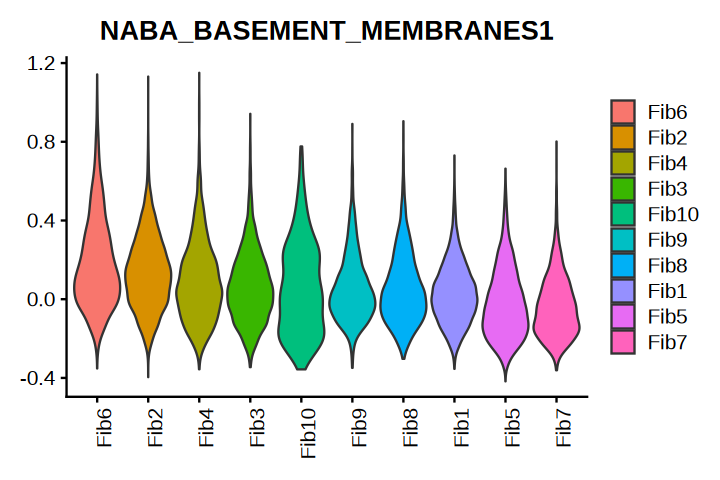

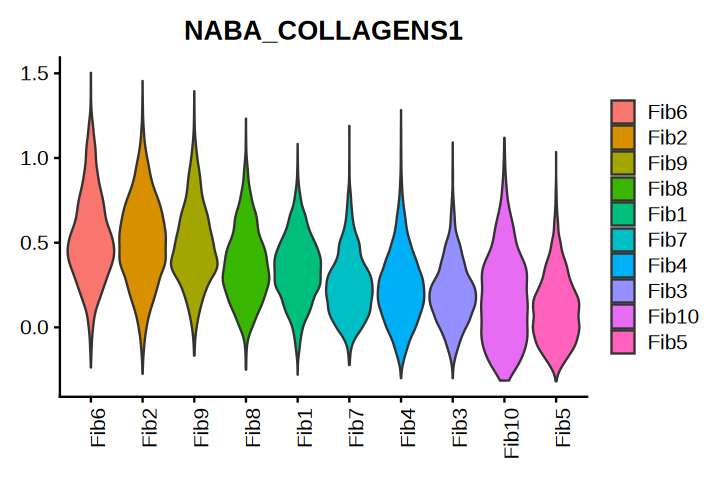

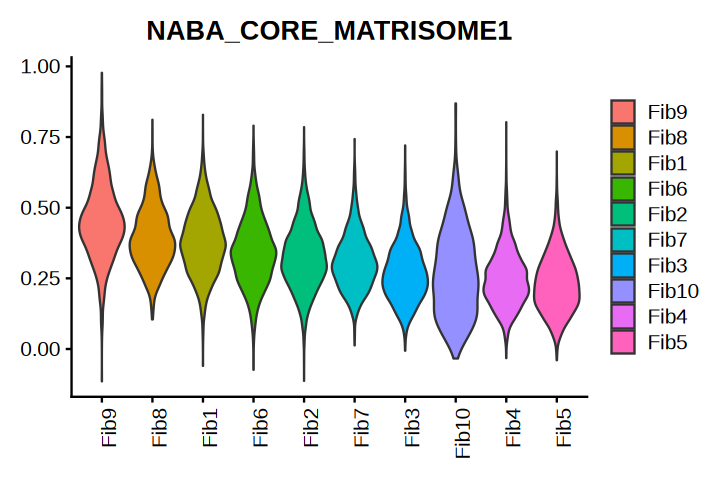

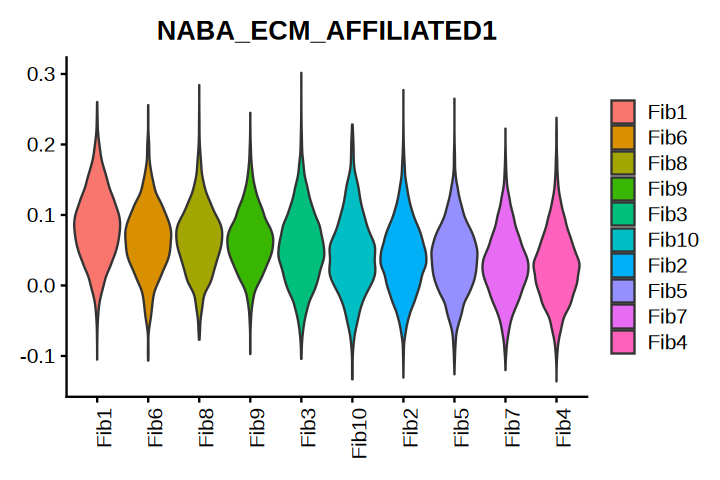

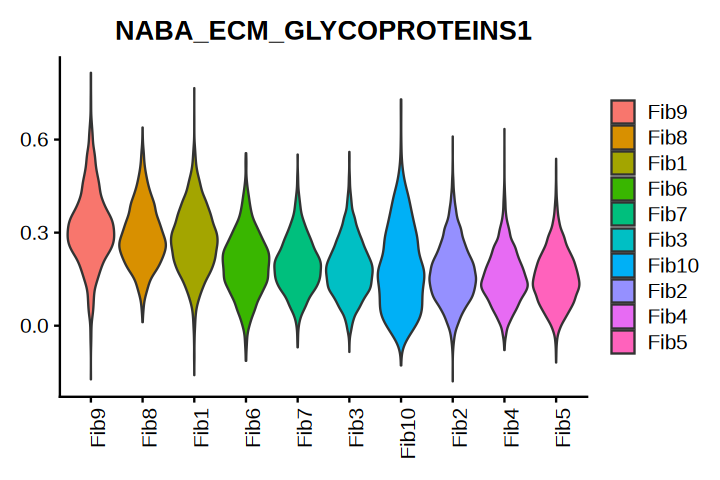

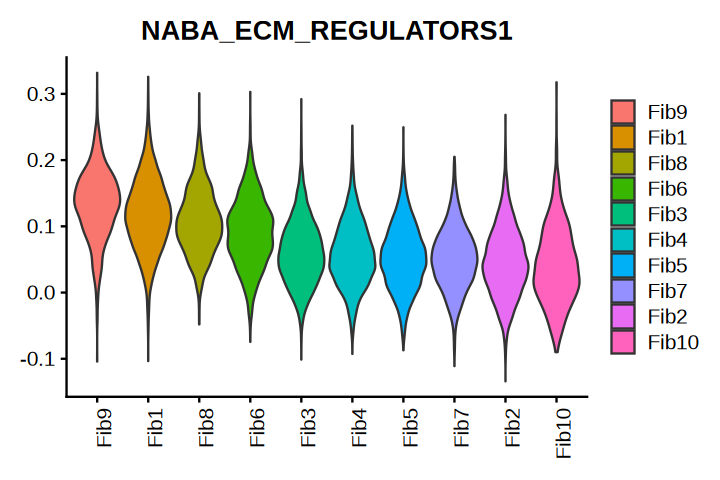

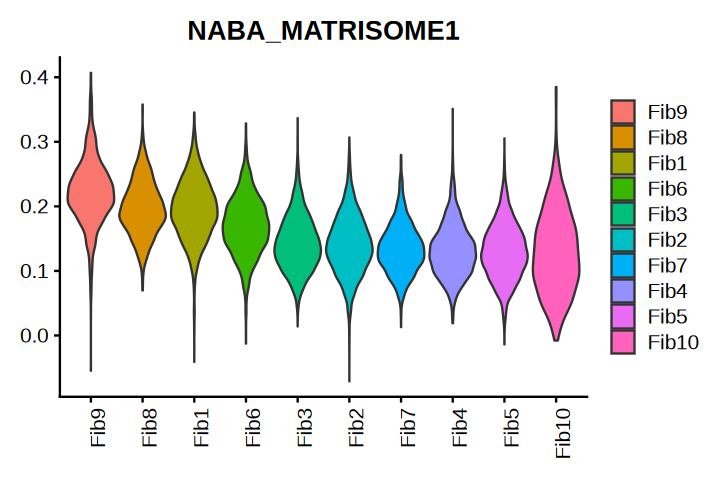

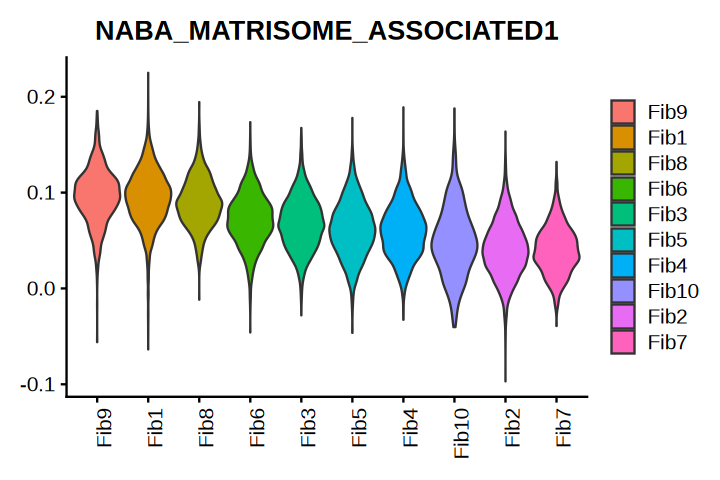

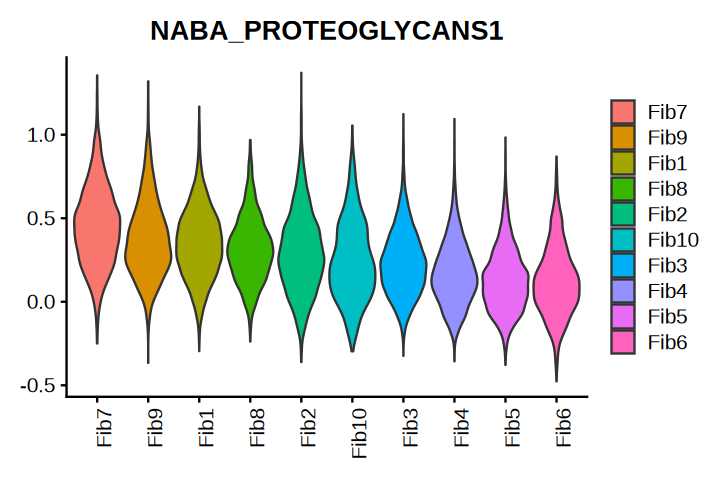

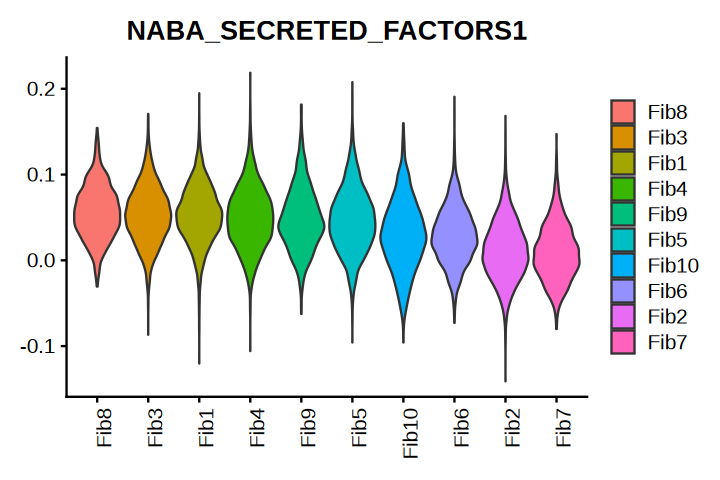

In [26]:
for (gset in NABA_SETS){
    p <- VlnPlot(obj, features = paste0(gset, '1'), group.by = 'sub_clusters', pt.size = 0, sort = TRUE) + 
        theme(axis.title.x=element_blank(),
              axis.text.x=element_text(angle = 90))
    
    print(p)
}